In [41]:
%pip install pymupdf pillow ipython
%mkdir Images

Note: you may need to restart the kernel to use updated packages.
mkdir: cannot create directory ‘Images’: File exists


In [42]:
import fitz
import os
from PIL import Image
from IPython.display import Image, display
from pathlib import Path


### `get_Text_and_Images(file_path)`
- **Input:**  
  `file_path` (str) – Path to the PDF file.

- **Output:**  
  `(Images_list, Text_list)` – Lists of raw image and text blocks from the PDF.

- **Summary:**  
  Extracts all text and image blocks from a PDF using `PyMuPDF`, saves images (excluding logo and images under 700kb), and records page info.


In [43]:
def get_Text_and_Images(file_path="../files/O-RAN.WG3.TS.E2AP-R004-v07.00.pdf"):
    #file_path = "files/O-RAN.WG3.TS.E2AP-R004-v07.00 (1).pdf"
    folder_name = os.path.splitext(os.path.basename(file_path))[0]

    # Create the full path: ./Images/<folder_name>
    output_dir = Path("Images") / folder_name
    output_dir.mkdir(parents=True, exist_ok=True)

    #open pdf
    pdf_file = fitz.open(file_path)

    #define pdf length
    page_nums = len(pdf_file)


    Images_list= []
    Text_list = []
    for page_num in range(page_nums):
        page = pdf_file[page_num]
        page_dict = page.get_text("dict")
        blocks = page_dict["blocks"]
        
        textblocks = [b for b in blocks if b["type"] == 0]
        imageblocks = [b for b in blocks if b["type"] == 1]


        for t in textblocks:
            t['page'] = int(page_num)+1
        Text_list.extend(textblocks)
        
        with open("../files/logo.jpeg","rb") as logo:
            logo_bytes = logo.read()

        page_list = [
        image for image in imageblocks
        if image["image"] and image["image"] != logo_bytes and len(image["image"]) > 700
        ]
        if page_list:
            for p in page_list:
                p['page'] = int(page_num)+1
            Images_list.extend(page_list)
        for i,img in enumerate(page_list, start =1):
            bytes = img["image"]
            ext = img["ext"]
            name = F"page{page_num+1}_img{i}.{ext}"

            with open(os.path.join(output_dir,name),'wb') as image_file:
                image_file.write(bytes)
                image_file.close()
    return Images_list, Text_list

### `clean_images(Images_list)`
- **Input:**  
  `Images_list` (list) – Raw image blocks from the PDF.

- **Output:**  
  `cleaned_images` – List of dictionaries with `img`, `bbox`, and `page`.

- **Summary:**  
  Filters image data to retain only relevant metadata (image bytes, position, page).

In [44]:
def clean_images(Images_list):
    cleaned_images = []
    for img in Images_list:
        cleaned_images.append({"img":img['image'],"bbox":img['bbox'],"page":img['page']})
    return cleaned_images


### `clean_text(Text_list)`
- **Input:**  
  `Text_list` (list) – Raw text blocks from the PDF.

- **Output:**  
  `cleaned_text` – List of dictionaries with full text string, `bbox`, and `page`.

- **Summary:**  
  Joins individual text spans into blocks and keeps only non-empty entries with layout data.

In [45]:
def clean_text(Text_list):
    cleaned_text = []
    for i in range(len(Text_list)):
        Textblock = []
        bbox = None
        page = None
        for line in Text_list[i]['lines']:
            for span in line['spans']:
                Textblock.append(span['text'])
            bbox = Text_list[i]['bbox']
            page = Text_list[i]['page']
        if "".join(Textblock).strip() != "":
            cleaned_text.append({"text":"".join(Textblock),"bbox":bbox,"page":page})
    return cleaned_text

### `find_caption(image, cleaned_text)`
- **Input:**  
  `image` (dict) – A cleaned image dictionary.  
  `cleaned_text` (list) – List of cleaned text blocks.

- **Output:**  
  `caption_text` (str) – Text located closest below the image on the same page.

- **Summary:**  
  Finds the nearest text block vertically below the image, assuming it's the caption.

In [46]:
def find_caption(image,cleaned_text):
    best_text = None
    min_distance = float('inf')
    for text in cleaned_text:
        if text["page"] == image["page"]:
            if text["bbox"][1] > image["bbox"][3]:
                vertical_distance = image["bbox"][1] - text["bbox"][3]
                if round(abs(vertical_distance)) < min_distance:
                    min_distance = abs(vertical_distance)
                    best_text = text
    return best_text['text']

### `add_captions(cleaned_image, cleaned_text)`
- **Input:**  
  `cleaned_image` (list) – List of cleaned image dictionaries.  
  `cleaned_text` (list) – List of cleaned text blocks.

- **Output:**  
  `captioned_photos` – Same image list, but with a new `caption` key added to each image.

- **Summary:**  
  Assigns each image a caption by searching for the closest text block below it on the same page.


In [47]:
def add_captions(cleaned_image,cleaned_text):
    captioned_photos = cleaned_image
    for img in captioned_photos:
        img['caption']= find_caption(img,cleaned_text)
    return captioned_photos

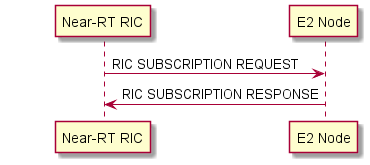

Figure 8.2.1.2-1: RIC Subscription procedure, successful operation  on page 15


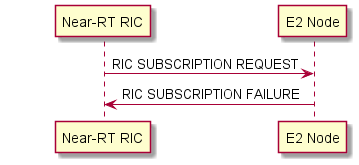

Figure 8.2.1.3-1: RIC Subscription procedure, unsuccessful operation  on page 17


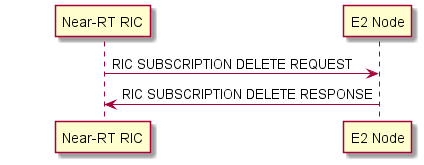

Figure 8.2.2.2-1: RIC Subscription Delete procedure, successful operation  on page 18


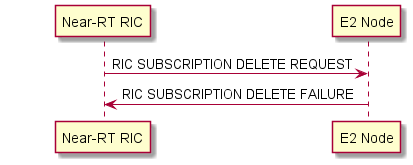

Figure 8.2.2.3-1: RIC Subscription Delete procedure, unsuccessful operation  on page 18


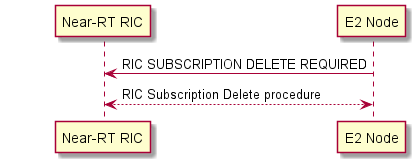

Figure 8.2.2A.2-1: RIC Subscription Delete Required procedure, successful operation  on page 19


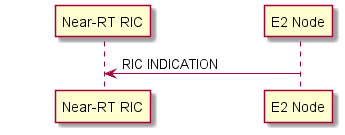

Figure 8.2.3.2-1: RIC Indication procedure, successful operation  on page 22


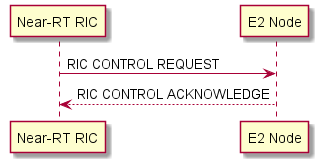

Figure 8.2.4.2-1: RIC Control procedure, successful operation  on page 23


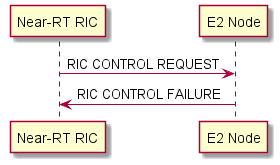

Figure 8.2.4.3-1: RIC Control procedure, unsuccessful operation  on page 24


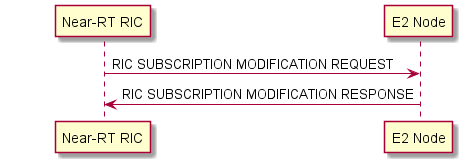

Figure 8.2.5.2-1: RIC Subscription Modification procedure, successful operation  on page 25


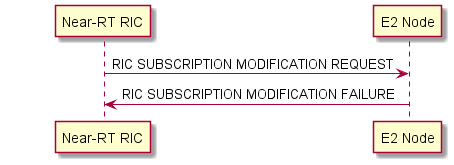

Figure 8.2.5.3-1: RIC Subscription Modification procedure, unsuccessful operation  on page 27


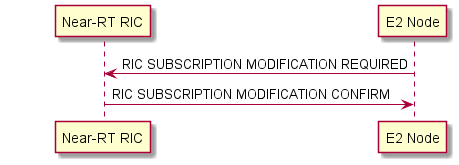

Figure 8.2.6.2-1: RIC Subscription Modification Required procedure, successful operation  on page 28


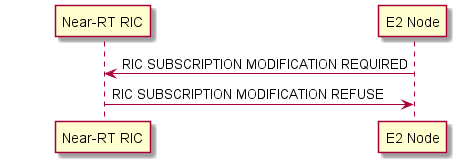

Figure 8.2.6.3-1: RIC Subscription Modification Required procedure, unsuccessful operation  on page 29


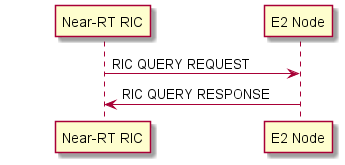

Figure 8.2.7.2-1: RIC Query procedure, successful operation  on page 30


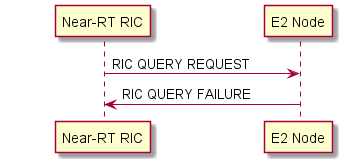

Figure 8.2.7.3-1: RIC Query procedure, unsuccessful operation  on page 30


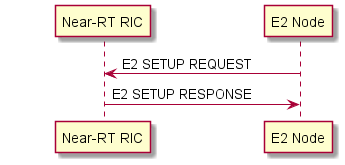

Figure 8.3.1.2-1: E2 Setup procedure, successful operation  on page 39


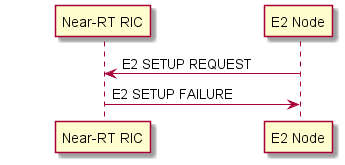

Figure 8.3.1.3-1: E2 Setup procedure, unsuccessful operation  on page 39


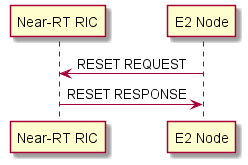

Figure 8.3.2.2-1: Reset, successful operation (E2 Node Initiated)  on page 40


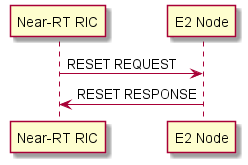

Figure 8.3.2.2-2: Reset, successful operation (Near-RT RIC Initiated)  on page 40


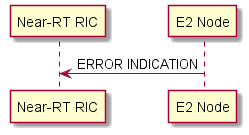

Figure 8.3.3.2-1: Error Indication, (E2 Node initiated) successful operation  on page 41


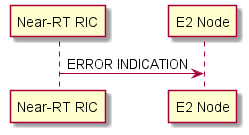

Figure 8.3.3.2-2: Error Indication, (Near-RT RIC Initiated) successful operation  on page 41


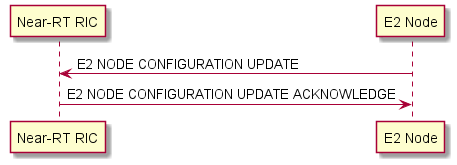

Figure 8.3.5.2-1: E2 Node Configuration Update procedure, successful operation  on page 45


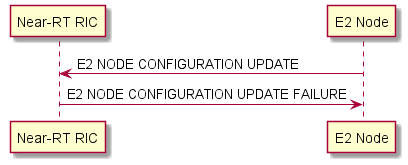

Figure 8.3.5.3-1: E2 Node Configuration Update procedure, unsuccessful operation  on page 46


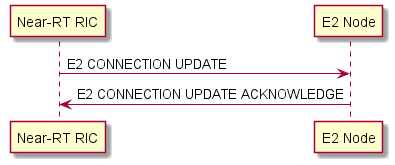

Figure 8.3.6.2-1: E2 Connection Update procedure, successful operation  on page 47


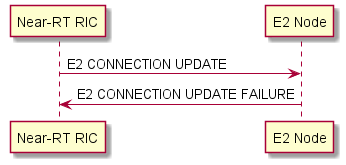

Figure 8.3.6.3-1: E2 Connection Update procedure, unsuccessful operation  on page 48


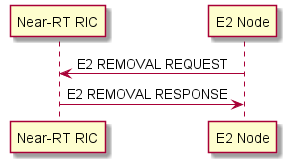

Figure 8.3.7.2-1: E2 Removal, successful operation (E2 Node Initiated)  on page 49


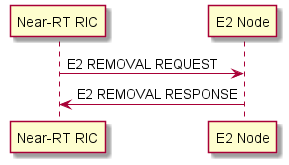

Figure 8.3.7.2-2: E2 Removal, successful operation (Near-RT RIC Initiated)  on page 49


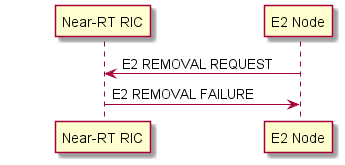

Figure 8.3.7.3-1: E2 Removal procedure (E2 Node Initiated), unsuccessful operation  on page 50


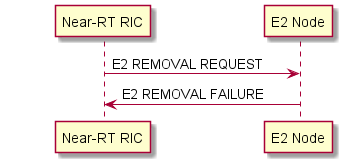

Figure 8.3.7.3-2: E2 Removal procedure (Near-RT RIC Initiated), unsuccessful operation  on page 50


In [48]:
Images_list,Text_list = get_Text_and_Images()

cleaned_images = clean_images(Images_list)
cleaned_text = clean_text(Text_list)
captioned_photos = add_captions(cleaned_images,cleaned_text)

for img in captioned_photos:
    display(Image(data=img['img']))
    print(img['caption'],f"on page {img['page']}")